In [70]:
# fix for pycharm jupyter
import os

import cv2
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

if not os.path.abspath(os.curdir).endswith("sneakers-ml"):
    os.chdir("../../")

os.path.abspath(os.curdir)

'/Users/dandex/PycharmProjects/sneakers-ml'

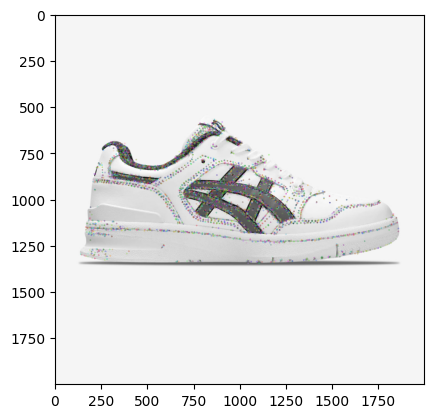

In [72]:
# test

img = cv2.imread("data/merged/images/by-brands/asics/0.jpeg")
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img, None)
sift_image = cv2.drawKeypoints(imgGray, keypoints, img)

plt.figure()
plt.imshow(sift_image, cmap="gray")

In [3]:
# https://www.codespeedy.com/find-similarity-between-two-images-in-python/
# https://stackoverflow.com/questions/50217364/sift-comparison-calculate-similarity-score-python
# https://stackoverflow.com/questions/43220408/measure-of-image-similarity-for-feature-matching

# 1. SIFT

In [108]:
df = pd.read_csv("data/merged/metadata/brands_dataset.csv")
df.drop('unique_images_count', axis=1, inplace=True)
df

,brand_merge,images
0,adidas,data/merged/images/by-brands/adidas
1,asics,data/merged/images/by-brands/asics
2,autry,data/merged/images/by-brands/autry
3,clarks,data/merged/images/by-brands/clarks
4,converse,data/merged/images/by-brands/converse
5,crocs,data/merged/images/by-brands/crocs
6,diadora,data/merged/images/by-brands/diadora
7,etonic,data/merged/images/by-brands/etonic
8,fila,data/merged/images/by-brands/fila
9,hi tec,data/merged/images/by-brands/hi tec


In [109]:
# flat map dataset into brand -> images
df['image_path'] = df['images'].apply(lambda path: [os.path.join(path, file) for file in os.listdir(path)])
df.drop('images', axis=1, inplace=True)
df = df.explode('image_path')
df

,brand_merge,image_path
0,adidas,data/merged/images/by-brands/adidas/723.jpeg
0,adidas,data/merged/images/by-brands/adidas/689.jpeg
0,adidas,data/merged/images/by-brands/adidas/373.jpeg
0,adidas,data/merged/images/by-brands/adidas/666.jpeg
0,adidas,data/merged/images/by-brands/adidas/236.jpeg
...,...,...
29,y 3,data/merged/images/by-brands/y 3/4.jpeg
29,y 3,data/merged/images/by-brands/y 3/5.jpeg
29,y 3,data/merged/images/by-brands/y 3/9.jpeg
29,y 3,data/merged/images/by-brands/y 3/2.jpeg


In [115]:
tqdm.pandas()


def calc_sift_similarity(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image8bit, None)
    return keypoints, descriptors


df['keypoints'], df['descriptors'] = zip(*df['image_path'].progress_apply(calc_sift_similarity))
df.to_csv("data/features/brands_dataset_sift.csv", index=False)

  0%|          | 0/5892 [00:00<?, ?it/s]

# 2. Image similarity

In [140]:
img1, keypoints1 = cv2.imread(df.iloc[0]['image_path']), df.iloc[0]['keypoints']
img2, keypoints2 = cv2.imread(df.iloc[1]['image_path']), df.iloc[1]['keypoints']

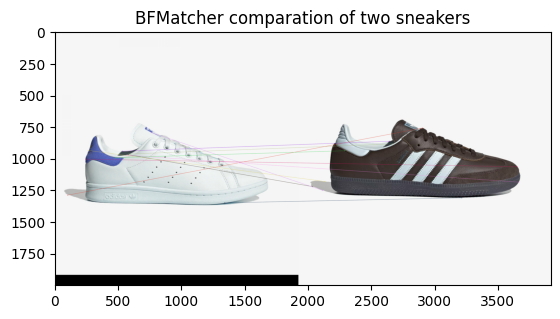

In [141]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(df.iloc[0]['descriptors'], df.iloc[1]['descriptors'])
matches = sorted(matches, key=lambda x: x.distance)

plt.imshow(
    cv2.drawMatches(
        img1, keypoints1, img2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
)
plt.title('BFMatcher comparation of two sneakers')
plt.show()

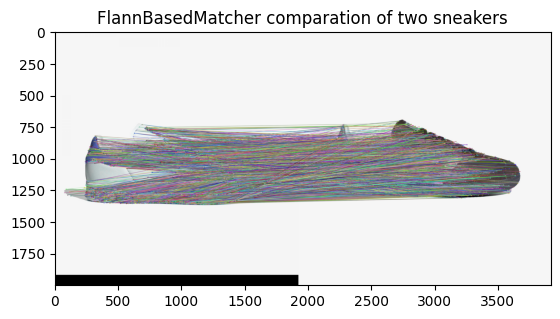

In [143]:
flann = cv2.FlannBasedMatcher({"algorithm": 0, "trees": 5}, {})
matches = flann.knnMatch(df.iloc[0]['descriptors'], df.iloc[1]['descriptors'], k=2)

plt.imshow(cv2.drawMatchesKnn(img1, keypoints1, img2, keypoints2, matches, None))
plt.title('FlannBasedMatcher comparation of two sneakers')
plt.show()

In [181]:
def flann_match(
    df: pd.DataFrame, example: pd.Series, distance_threshold: float = 0.7, good_count: int = 10, k: int = 2
):
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        if example['image_path'] == row['image_path']:
            continue

        matches = flann.knnMatch(example['descriptors'], row['descriptors'], k=k)
        good = []
        for m, n in matches:
            if m.distance < distance_threshold * n.distance:
                good.append([m])

        if len(good) > good_count:
            return row
    return None

Trying to find match for: data/merged/images/by-brands/adidas/689.jpeg


  0%|          | 0/5892 [00:00<?, ?it/s]

Found match: data/merged/images/by-brands/adidas/666.jpeg


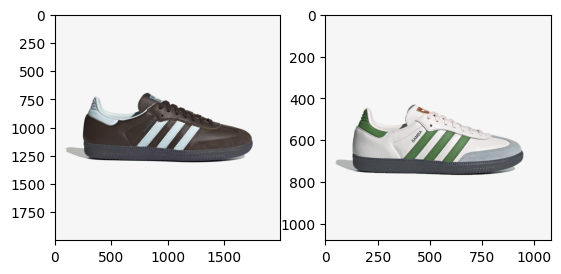

In [182]:
# take 1 image and find most similar

example_index = 1
example = df.iloc[example_index]

print("Trying to find match for:", example['image_path'])
match = flann_match(df, example, distance_threshold=0.7, k=2, good_count=30)

if match is not None:
    print(f"Found match: {match['image_path']}")
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    plt.imshow(cv2.imread(example['image_path']))
    f.add_subplot(1, 2, 2)
    plt.imshow(cv2.imread(match['image_path']))
    plt.show()
else:
    print("No match found")